<a href="https://colab.research.google.com/github/singhnidh/Plant-disease-detection-using-Deep-Learning-and-Machine-Vision/blob/main/Model/1_FINAL_RESNET_MODEL_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
NUM_CLASSES = 20

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 20
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1



image_size = IMAGE_RESIZE
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

download_dir = Path('/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset')

train_data_dir = download_dir/' dataset_original'
test_data_dir = download_dir/' Augmented Dataset'

class_subset = os.listdir(download_dir/' dataset_original')
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)


cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/model notebook/my_model_tl_ft_res333.keras', monitor = 'val_loss', save_best_only = True,
                             mode='min',
                             save_freq=1,
                             verbose=1)

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights='imagenet'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False
model.summary()
from tensorflow.keras.optimizers import SGD

#from tensorflow.keras import optimizers
import tensorflow as tf
#sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

sgd = tf.keras.optimizers.legacy.SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)
fit_history = model.fit(
        traingen,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validgen,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.save("/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/model notebook/my_model_tl_ft_res333.keras")

print(fit_history.history.keys())

Found 16545 images belonging to 20 classes.
Found 2911 images belonging to 20 classes.
Found 10472 images belonging to 20 classes.
94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 20)                40980     
                                                                 
Total params: 23628692 (90.14 MB)
Trainable params: 40980 (160.08 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoch 1/20


 1/10 [==>...........................] - ETA: 6:10 - loss: 3.8338 - accuracy: 0.0469

 2/10 [=====>........................] - ETA: 3:01 - loss: 3.4861 - accuracy: 0.0469

 3/10 [========>.....................] - ETA: 2:42 - loss: 3.3241 - accuracy: 0.0729

 4/10 [===========>..................] - ETA: 2:15 - loss: 3.1798 - accuracy: 0.0938

 5/10 [==============>...............] - ETA: 1:57 - loss: 3.0304 - accuracy: 0.1344

 6/10 [=================>............] - ETA: 1:33 - loss: 2.9857 - accuracy: 0.1458

 7/10 [====================>.........] - ETA: 1:09 - loss: 2.8856 - accuracy: 0.1696

 8/10 [=======================>......] - ETA: 46s - loss: 2.7879 - accuracy: 0.1973 

 9/10 [==========================>...] - ETA: 23s - loss: 2.7212 - accuracy: 0.2101

10/10 [==============================] - 538s 55s/step - loss: 2.6331 - accuracy: 0.2359 - val_loss: 1.7216 - val_accuracy: 0.5188
Epoch 2/20


 1/10 [==>...........................] - ETA: 4:34 - loss: 1.6881 - accuracy: 0.4844

 2/10 [=====>........................] - ETA: 3:05 - loss: 1.6264 - accuracy: 0.5391

 3/10 [========>.....................] - ETA: 2:39 - loss: 1.5382 - accuracy: 0.5781

 4/10 [===========>..................] - ETA: 2:17 - loss: 1.5096 - accuracy: 0.5742

 5/10 [==============>...............] - ETA: 1:53 - loss: 1.4446 - accuracy: 0.5875

 6/10 [=================>............] - ETA: 1:31 - loss: 1.4159 - accuracy: 0.5885

 7/10 [====================>.........] - ETA: 1:07 - loss: 1.3918 - accuracy: 0.5871

 8/10 [=======================>......] - ETA: 45s - loss: 1.3401 - accuracy: 0.5996 

 9/10 [==========================>...] - ETA: 22s - loss: 1.3192 - accuracy: 0.6094

10/10 [==============================] - 434s 45s/step - loss: 1.3110 - accuracy: 0.6125 - val_loss: 1.2008 - val_accuracy: 0.6500
Epoch 3/20


 1/10 [==>...........................] - ETA: 4:53 - loss: 0.9462 - accuracy: 0.7031

 2/10 [=====>........................] - ETA: 2:38 - loss: 1.0646 - accuracy: 0.6641

 3/10 [========>.....................] - ETA: 2:26 - loss: 1.0376 - accuracy: 0.6823

 4/10 [===========>..................] - ETA: 2:06 - loss: 1.0539 - accuracy: 0.6797

 5/10 [==============>...............] - ETA: 1:44 - loss: 1.0615 - accuracy: 0.6844

 6/10 [=================>............] - ETA: 1:24 - loss: 1.0421 - accuracy: 0.7057

 7/10 [====================>.........] - ETA: 1:02 - loss: 1.0287 - accuracy: 0.7076

 8/10 [=======================>......] - ETA: 42s - loss: 1.0074 - accuracy: 0.7090 

 9/10 [==========================>...] - ETA: 20s - loss: 0.9908 - accuracy: 0.7135

10/10 [==============================] - 425s 44s/step - loss: 0.9635 - accuracy: 0.7172 - val_loss: 0.8149 - val_accuracy: 0.7500
Epoch 4/20


 1/10 [==>...........................] - ETA: 4:34 - loss: 0.8731 - accuracy: 0.6406

 2/10 [=====>........................] - ETA: 2:37 - loss: 0.8355 - accuracy: 0.7109

 3/10 [========>.....................] - ETA: 2:15 - loss: 0.7709 - accuracy: 0.7448

 4/10 [===========>..................] - ETA: 1:58 - loss: 0.7636 - accuracy: 0.7656

 5/10 [==============>...............] - ETA: 1:38 - loss: 0.7923 - accuracy: 0.7625

 6/10 [=================>............] - ETA: 1:19 - loss: 0.7841 - accuracy: 0.7656

 7/10 [====================>.........] - ETA: 59s - loss: 0.7718 - accuracy: 0.7723 

 8/10 [=======================>......] - ETA: 39s - loss: 0.7750 - accuracy: 0.7793

 9/10 [==========================>...] - ETA: 20s - loss: 0.7512 - accuracy: 0.7812

10/10 [==============================] - 357s 36s/step - loss: 0.7442 - accuracy: 0.7812 - val_loss: 0.6707 - val_accuracy: 0.7937
Epoch 5/20


 1/10 [==>...........................] - ETA: 4:24 - loss: 0.7706 - accuracy: 0.8750

 2/10 [=====>........................] - ETA: 53s - loss: 0.7261 - accuracy: 0.8351 

 3/10 [========>.....................] - ETA: 1:43 - loss: 0.6895 - accuracy: 0.8137

 4/10 [===========>..................] - ETA: 1:34 - loss: 0.6430 - accuracy: 0.8400

 5/10 [==============>...............] - ETA: 1:23 - loss: 0.6114 - accuracy: 0.8443

 6/10 [=================>............] - ETA: 1:08 - loss: 0.6331 - accuracy: 0.8442

 7/10 [====================>.........] - ETA: 52s - loss: 0.6211 - accuracy: 0.8465 

 8/10 [=======================>......] - ETA: 35s - loss: 0.6302 - accuracy: 0.8295

 9/10 [==========================>...] - ETA: 17s - loss: 0.6347 - accuracy: 0.8275

10/10 [==============================] - 332s 34s/step - loss: 0.6377 - accuracy: 0.8210 - val_loss: 0.6404 - val_accuracy: 0.8000
Epoch 6/20


 1/10 [==>...........................] - ETA: 4:45 - loss: 0.4676 - accuracy: 0.8438

 2/10 [=====>........................] - ETA: 2:27 - loss: 0.4358 - accuracy: 0.8828

 3/10 [========>.....................] - ETA: 2:08 - loss: 0.4853 - accuracy: 0.8646

 4/10 [===========>..................] - ETA: 1:53 - loss: 0.4832 - accuracy: 0.8750

 5/10 [==============>...............] - ETA: 1:33 - loss: 0.5059 - accuracy: 0.8562

 6/10 [=================>............] - ETA: 1:13 - loss: 0.4917 - accuracy: 0.8646

 7/10 [====================>.........] - ETA: 55s - loss: 0.4895 - accuracy: 0.8661 

 8/10 [=======================>......] - ETA: 36s - loss: 0.5125 - accuracy: 0.8574

 9/10 [==========================>...] - ETA: 18s - loss: 0.5147 - accuracy: 0.8507

10/10 [==============================] - 328s 33s/step - loss: 0.5197 - accuracy: 0.8522 - val_loss: 0.5183 - val_accuracy: 0.8531
Epoch 7/20


 1/10 [==>...........................] - ETA: 4:23 - loss: 0.7128 - accuracy: 0.7969

 2/10 [=====>........................] - ETA: 2:30 - loss: 0.6594 - accuracy: 0.7891

 3/10 [========>.....................] - ETA: 2:14 - loss: 0.6690 - accuracy: 0.7917

 4/10 [===========>..................] - ETA: 2:04 - loss: 0.6716 - accuracy: 0.7930

 5/10 [==============>...............] - ETA: 1:37 - loss: 0.6669 - accuracy: 0.7875

 6/10 [=================>............] - ETA: 1:16 - loss: 0.6670 - accuracy: 0.7891

 7/10 [====================>.........] - ETA: 55s - loss: 0.6750 - accuracy: 0.7835 

 8/10 [=======================>......] - ETA: 36s - loss: 0.6492 - accuracy: 0.7949

 9/10 [==========================>...] - ETA: 18s - loss: 0.6364 - accuracy: 0.7986

10/10 [==============================] - 339s 34s/step - loss: 0.6231 - accuracy: 0.8031 - val_loss: 0.5028 - val_accuracy: 0.8594
Epoch 8/20


 1/10 [==>...........................] - ETA: 4:31 - loss: 0.5877 - accuracy: 0.7812

 2/10 [=====>........................] - ETA: 2:12 - loss: 0.5069 - accuracy: 0.8438

 3/10 [========>.....................] - ETA: 1:59 - loss: 0.4671 - accuracy: 0.8542

 4/10 [===========>..................] - ETA: 1:47 - loss: 0.4786 - accuracy: 0.8516

 5/10 [==============>...............] - ETA: 1:26 - loss: 0.4821 - accuracy: 0.8469

 6/10 [=================>............] - ETA: 1:07 - loss: 0.4806 - accuracy: 0.8385

 7/10 [====================>.........] - ETA: 49s - loss: 0.4617 - accuracy: 0.8438 

 8/10 [=======================>......] - ETA: 33s - loss: 0.4937 - accuracy: 0.8359

 9/10 [==========================>...] - ETA: 17s - loss: 0.5118 - accuracy: 0.8299

10/10 [==============================] - 325s 33s/step - loss: 0.5027 - accuracy: 0.8375 - val_loss: 0.5614 - val_accuracy: 0.8328
Epoch 9/20


 1/10 [==>...........................] - ETA: 4:20 - loss: 0.6170 - accuracy: 0.7969

 2/10 [=====>........................] - ETA: 2:17 - loss: 0.5362 - accuracy: 0.8125

 3/10 [========>.....................] - ETA: 2:06 - loss: 0.4479 - accuracy: 0.8594

 4/10 [===========>..................] - ETA: 1:43 - loss: 0.4325 - accuracy: 0.8711

 5/10 [==============>...............] - ETA: 1:26 - loss: 0.4160 - accuracy: 0.8813

 6/10 [=================>............] - ETA: 1:09 - loss: 0.4374 - accuracy: 0.8672

 7/10 [====================>.........] - ETA: 51s - loss: 0.4435 - accuracy: 0.8616 

 8/10 [=======================>......] - ETA: 33s - loss: 0.4541 - accuracy: 0.8574

 9/10 [==========================>...] - ETA: 16s - loss: 0.4514 - accuracy: 0.8594

10/10 [==============================] - 313s 32s/step - loss: 0.4658 - accuracy: 0.8531 - val_loss: 0.4688 - val_accuracy: 0.8562
Epoch 10/20


 1/10 [==>...........................] - ETA: 4:09 - loss: 0.3794 - accuracy: 0.9375

 2/10 [=====>........................] - ETA: 2:01 - loss: 0.3910 - accuracy: 0.9219

 3/10 [========>.....................] - ETA: 1:57 - loss: 0.4246 - accuracy: 0.9062

 4/10 [===========>..................] - ETA: 1:41 - loss: 0.4551 - accuracy: 0.8945

 5/10 [==============>...............] - ETA: 1:24 - loss: 0.4406 - accuracy: 0.8969

 6/10 [=================>............] - ETA: 1:07 - loss: 0.4467 - accuracy: 0.8828

 7/10 [====================>.........] - ETA: 52s - loss: 0.4443 - accuracy: 0.8772 

 8/10 [=======================>......] - ETA: 35s - loss: 0.4443 - accuracy: 0.8750

 9/10 [==========================>...] - ETA: 17s - loss: 0.4576 - accuracy: 0.8681

10/10 [==============================] - 326s 33s/step - loss: 0.4496 - accuracy: 0.8687 - val_loss: 0.4722 - val_accuracy: 0.8578
Epoch 11/20


 1/10 [==>...........................] - ETA: 4:10 - loss: 0.4141 - accuracy: 0.8750

 2/10 [=====>........................] - ETA: 2:00 - loss: 0.4373 - accuracy: 0.8828

 3/10 [========>.....................] - ETA: 1:50 - loss: 0.4655 - accuracy: 0.8750

 4/10 [===========>..................] - ETA: 1:34 - loss: 0.4873 - accuracy: 0.8555

 5/10 [==============>...............] - ETA: 1:15 - loss: 0.4994 - accuracy: 0.8406

 6/10 [=================>............] - ETA: 59s - loss: 0.5019 - accuracy: 0.8411 

 7/10 [====================>.........] - ETA: 46s - loss: 0.4925 - accuracy: 0.8371

 8/10 [=======================>......] - ETA: 30s - loss: 0.4856 - accuracy: 0.8379

 9/10 [==========================>...] - ETA: 15s - loss: 0.4651 - accuracy: 0.8455

10/10 [==============================] - 305s 31s/step - loss: 0.4683 - accuracy: 0.8438 - val_loss: 0.4034 - val_accuracy: 0.8922
Epoch 12/20


 1/10 [==>...........................] - ETA: 3:45 - loss: 0.4566 - accuracy: 0.8750

 2/10 [=====>........................] - ETA: 1:52 - loss: 0.4926 - accuracy: 0.8516

 3/10 [========>.....................] - ETA: 1:37 - loss: 0.4572 - accuracy: 0.8646

 4/10 [===========>..................] - ETA: 1:26 - loss: 0.4512 - accuracy: 0.8594

 5/10 [==============>...............] - ETA: 1:10 - loss: 0.4237 - accuracy: 0.8719

 6/10 [=================>............] - ETA: 56s - loss: 0.4186 - accuracy: 0.8698 

 7/10 [====================>.........] - ETA: 41s - loss: 0.4113 - accuracy: 0.8772

 8/10 [=======================>......] - ETA: 28s - loss: 0.4072 - accuracy: 0.8750

 9/10 [==========================>...] - ETA: 14s - loss: 0.4011 - accuracy: 0.8750

10/10 [==============================] - 293s 30s/step - loss: 0.4182 - accuracy: 0.8687 - val_loss: 0.4292 - val_accuracy: 0.8594
Epoch 13/20


 1/10 [==>...........................] - ETA: 3:50 - loss: 0.5249 - accuracy: 0.8281

 2/10 [=====>........................] - ETA: 1:43 - loss: 0.4385 - accuracy: 0.8672

 3/10 [========>.....................] - ETA: 1:33 - loss: 0.4331 - accuracy: 0.8698

 4/10 [===========>..................] - ETA: 1:19 - loss: 0.4137 - accuracy: 0.8633

 5/10 [==============>...............] - ETA: 1:06 - loss: 0.4007 - accuracy: 0.8750

 6/10 [=================>............] - ETA: 53s - loss: 0.4023 - accuracy: 0.8724 

 7/10 [====================>.........] - ETA: 43s - loss: 0.4127 - accuracy: 0.8638

 8/10 [=======================>......] - ETA: 28s - loss: 0.4150 - accuracy: 0.8672

 9/10 [==========================>...] - ETA: 14s - loss: 0.4115 - accuracy: 0.8698

10/10 [==============================] - 294s 30s/step - loss: 0.4102 - accuracy: 0.8734 - val_loss: 0.3630 - val_accuracy: 0.9000
Epoch 14/20


 1/10 [==>...........................] - ETA: 3:40 - loss: 0.2822 - accuracy: 0.9688

 2/10 [=====>........................] - ETA: 1:52 - loss: 0.3268 - accuracy: 0.9141

 3/10 [========>.....................] - ETA: 1:27 - loss: 0.2925 - accuracy: 0.9271

 4/10 [===========>..................] - ETA: 1:16 - loss: 0.3154 - accuracy: 0.9180

 5/10 [==============>...............] - ETA: 1:04 - loss: 0.3337 - accuracy: 0.9094

 6/10 [=================>............] - ETA: 54s - loss: 0.3381 - accuracy: 0.9089 

 7/10 [====================>.........] - ETA: 40s - loss: 0.3325 - accuracy: 0.9085

 8/10 [=======================>......] - ETA: 26s - loss: 0.3288 - accuracy: 0.9102

 9/10 [==========================>...] - ETA: 13s - loss: 0.3149 - accuracy: 0.9149

10/10 [==============================] - 287s 29s/step - loss: 0.3251 - accuracy: 0.9141 - val_loss: 0.3239 - val_accuracy: 0.9000
Epoch 15/20


 1/10 [==>...........................] - ETA: 4:20 - loss: 0.3417 - accuracy: 0.8750

 2/10 [=====>........................] - ETA: 1:42 - loss: 0.3289 - accuracy: 0.8906

 3/10 [========>.....................] - ETA: 1:41 - loss: 0.3168 - accuracy: 0.8958

 4/10 [===========>..................] - ETA: 1:23 - loss: 0.3230 - accuracy: 0.8984

 5/10 [==============>...............] - ETA: 1:07 - loss: 0.3240 - accuracy: 0.9031

 6/10 [=================>............] - ETA: 53s - loss: 0.3386 - accuracy: 0.8906 

 7/10 [====================>.........] - ETA: 40s - loss: 0.3419 - accuracy: 0.8906

 8/10 [=======================>......] - ETA: 27s - loss: 0.3312 - accuracy: 0.9004

 9/10 [==========================>...] - ETA: 13s - loss: 0.3282 - accuracy: 0.9028

10/10 [==============================] - 280s 28s/step - loss: 0.3365 - accuracy: 0.8984 - val_loss: 0.3623 - val_accuracy: 0.8938
Epoch 16/20


 1/10 [==>...........................] - ETA: 3:34 - loss: 0.3024 - accuracy: 0.8906

 2/10 [=====>........................] - ETA: 1:33 - loss: 0.3105 - accuracy: 0.8906

 3/10 [========>.....................] - ETA: 1:26 - loss: 0.2884 - accuracy: 0.9115

 4/10 [===========>..................] - ETA: 1:16 - loss: 0.3316 - accuracy: 0.8984

 5/10 [==============>...............] - ETA: 1:02 - loss: 0.3238 - accuracy: 0.9000

 6/10 [=================>............] - ETA: 49s - loss: 0.3717 - accuracy: 0.8880 

 7/10 [====================>.........] - ETA: 37s - loss: 0.3958 - accuracy: 0.8772

 8/10 [=======================>......] - ETA: 25s - loss: 0.3902 - accuracy: 0.8828

 9/10 [==========================>...] - ETA: 13s - loss: 0.3784 - accuracy: 0.8872

10/10 [==============================] - 283s 29s/step - loss: 0.3794 - accuracy: 0.8844 - val_loss: 0.3597 - val_accuracy: 0.8797
Epoch 17/20


 1/10 [==>...........................] - ETA: 3:37 - loss: 0.3330 - accuracy: 0.8906

 2/10 [=====>........................] - ETA: 1:43 - loss: 0.3078 - accuracy: 0.9062

 3/10 [========>.....................] - ETA: 1:43 - loss: 0.3532 - accuracy: 0.8958

 4/10 [===========>..................] - ETA: 1:25 - loss: 0.3821 - accuracy: 0.8828

 5/10 [==============>...............] - ETA: 1:09 - loss: 0.4207 - accuracy: 0.8656

 6/10 [=================>............] - ETA: 53s - loss: 0.3961 - accuracy: 0.8776 

 7/10 [====================>.........] - ETA: 39s - loss: 0.3982 - accuracy: 0.8795

 8/10 [=======================>......] - ETA: 26s - loss: 0.3952 - accuracy: 0.8828

 9/10 [==========================>...] - ETA: 13s - loss: 0.3951 - accuracy: 0.8837

10/10 [==============================] - 284s 29s/step - loss: 0.3898 - accuracy: 0.8828 - val_loss: 0.3409 - val_accuracy: 0.8844
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


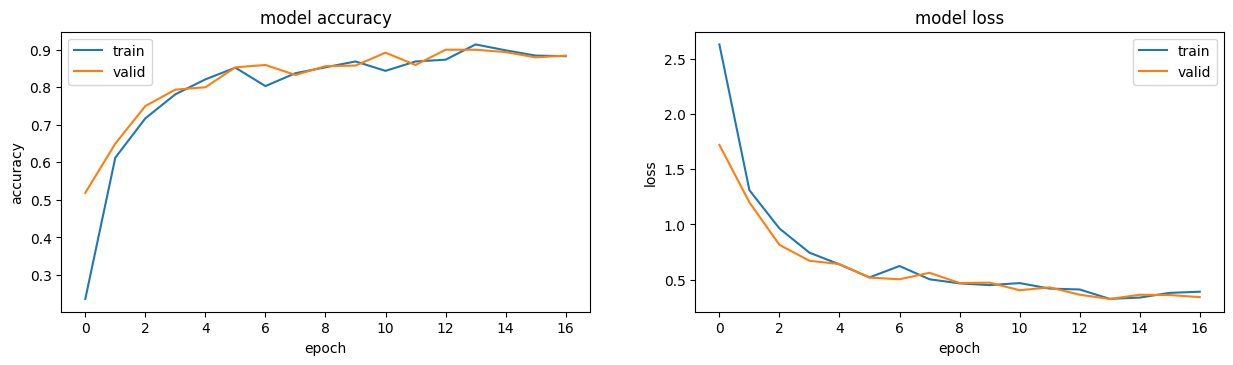

In [ ]:
# Confusion Matrix, Accuracy, F1 Score, Precision, Recall after fine-tuning
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

plt.figure(1, figsize = (15,8))

plt.subplot(221)
plt.plot(fit_history.history['accuracy'])
plt.plot(fit_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

In [ ]:
# Generate predictions
#model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

preds = model.predict(testgen)
pred_classes = np.argmax(preds, axis=1)

10472/10472 [==============================] - 3039s 290ms/step


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(true_classes, pred_classes)
print("Model Accuracy without Fine-Tuning: {:.2f}%".format(acc * 100))

Model Accuracy without Fine-Tuning: 83.23%


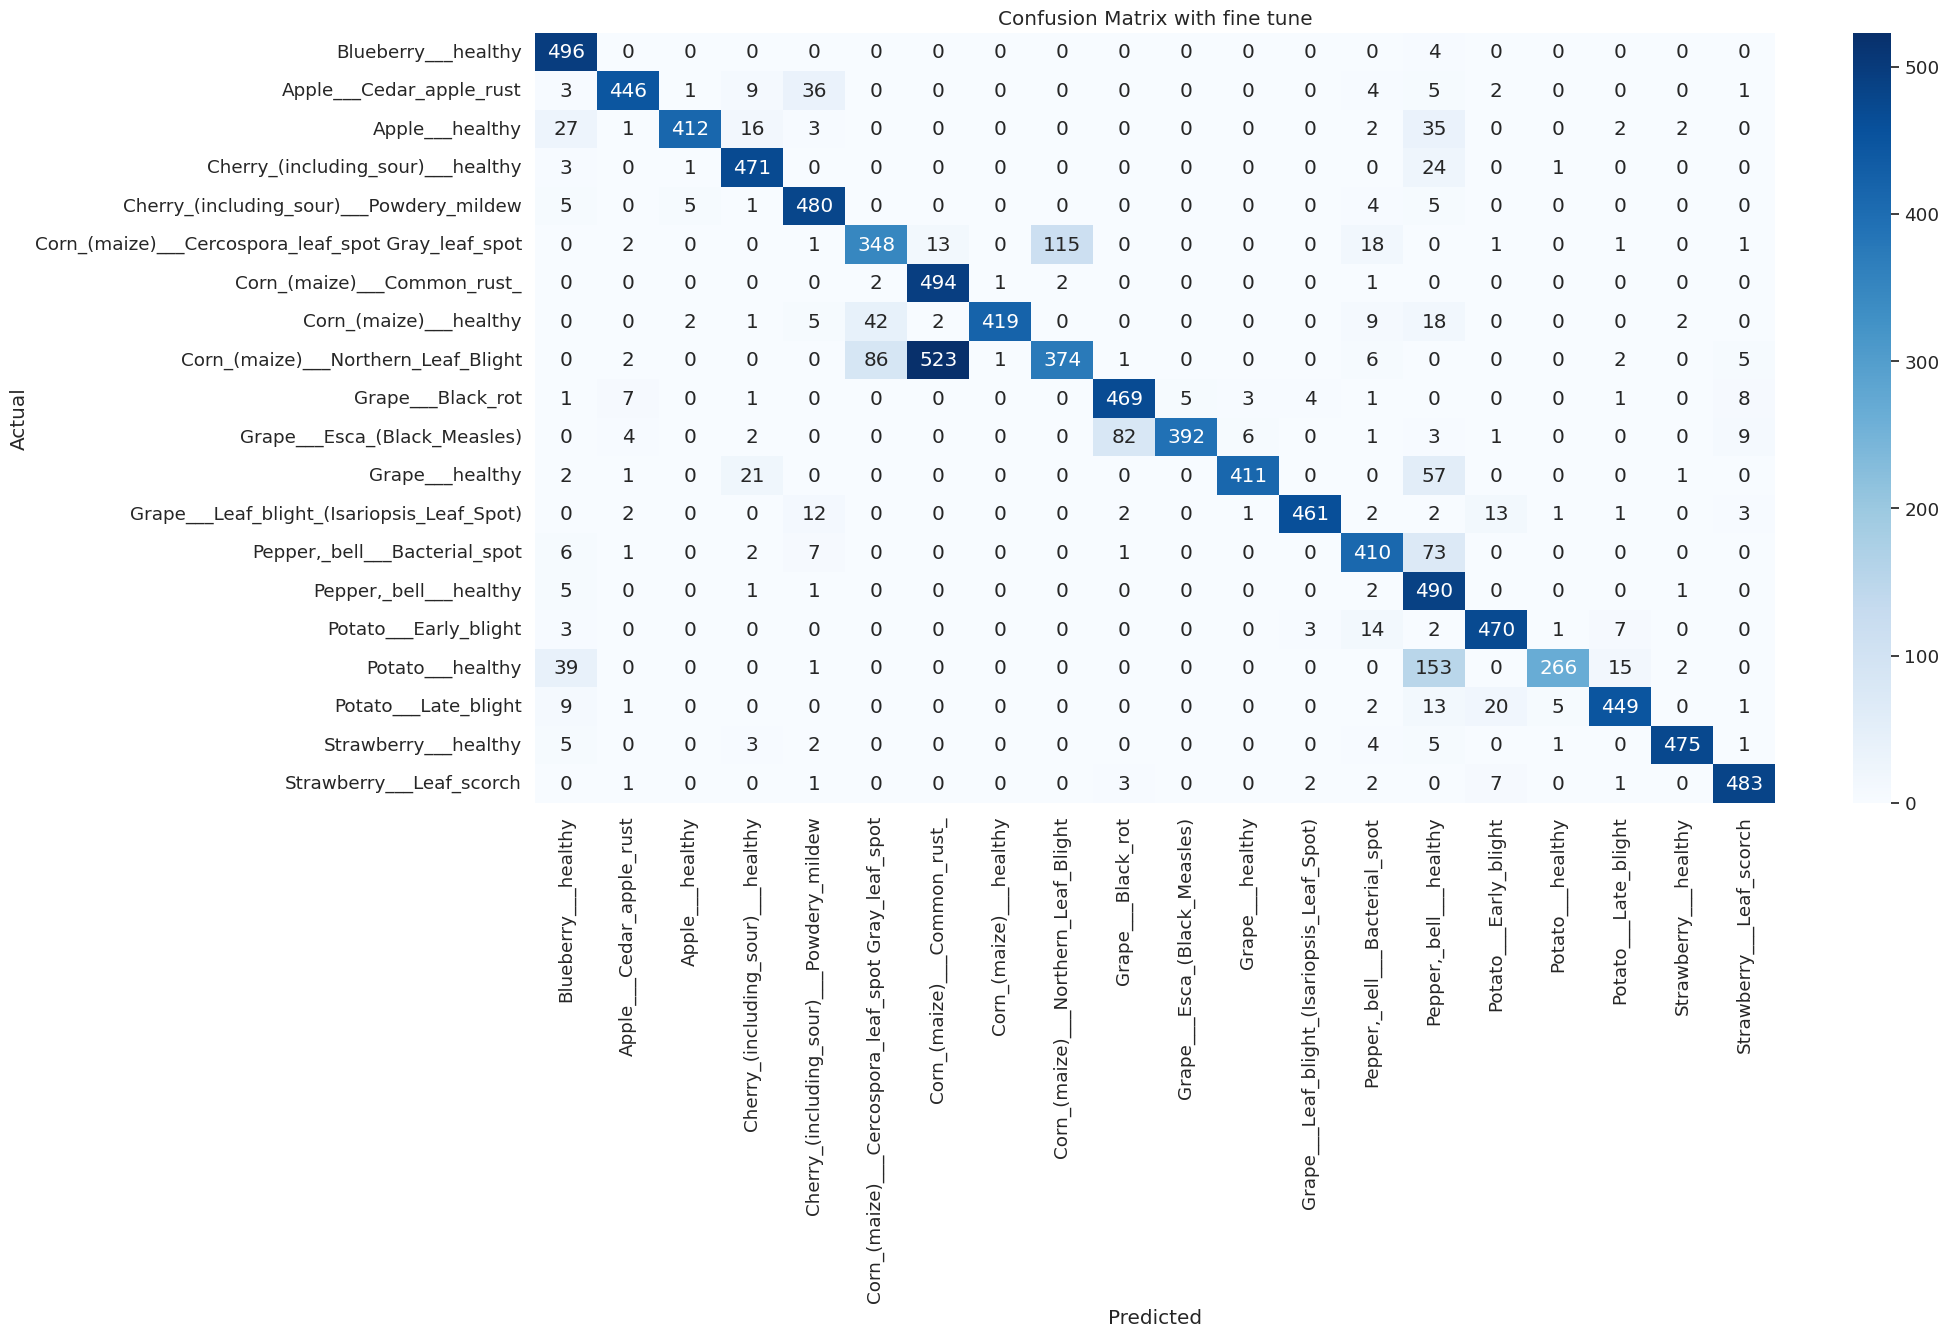

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
# Define class names if you have them
class_names = testgen.class_indices.keys()
# Create a heatmap
plt.figure(figsize=(20,10))
sns.set(font_scale=1.2)  # Adjust the font size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with fine tune')
plt.show()


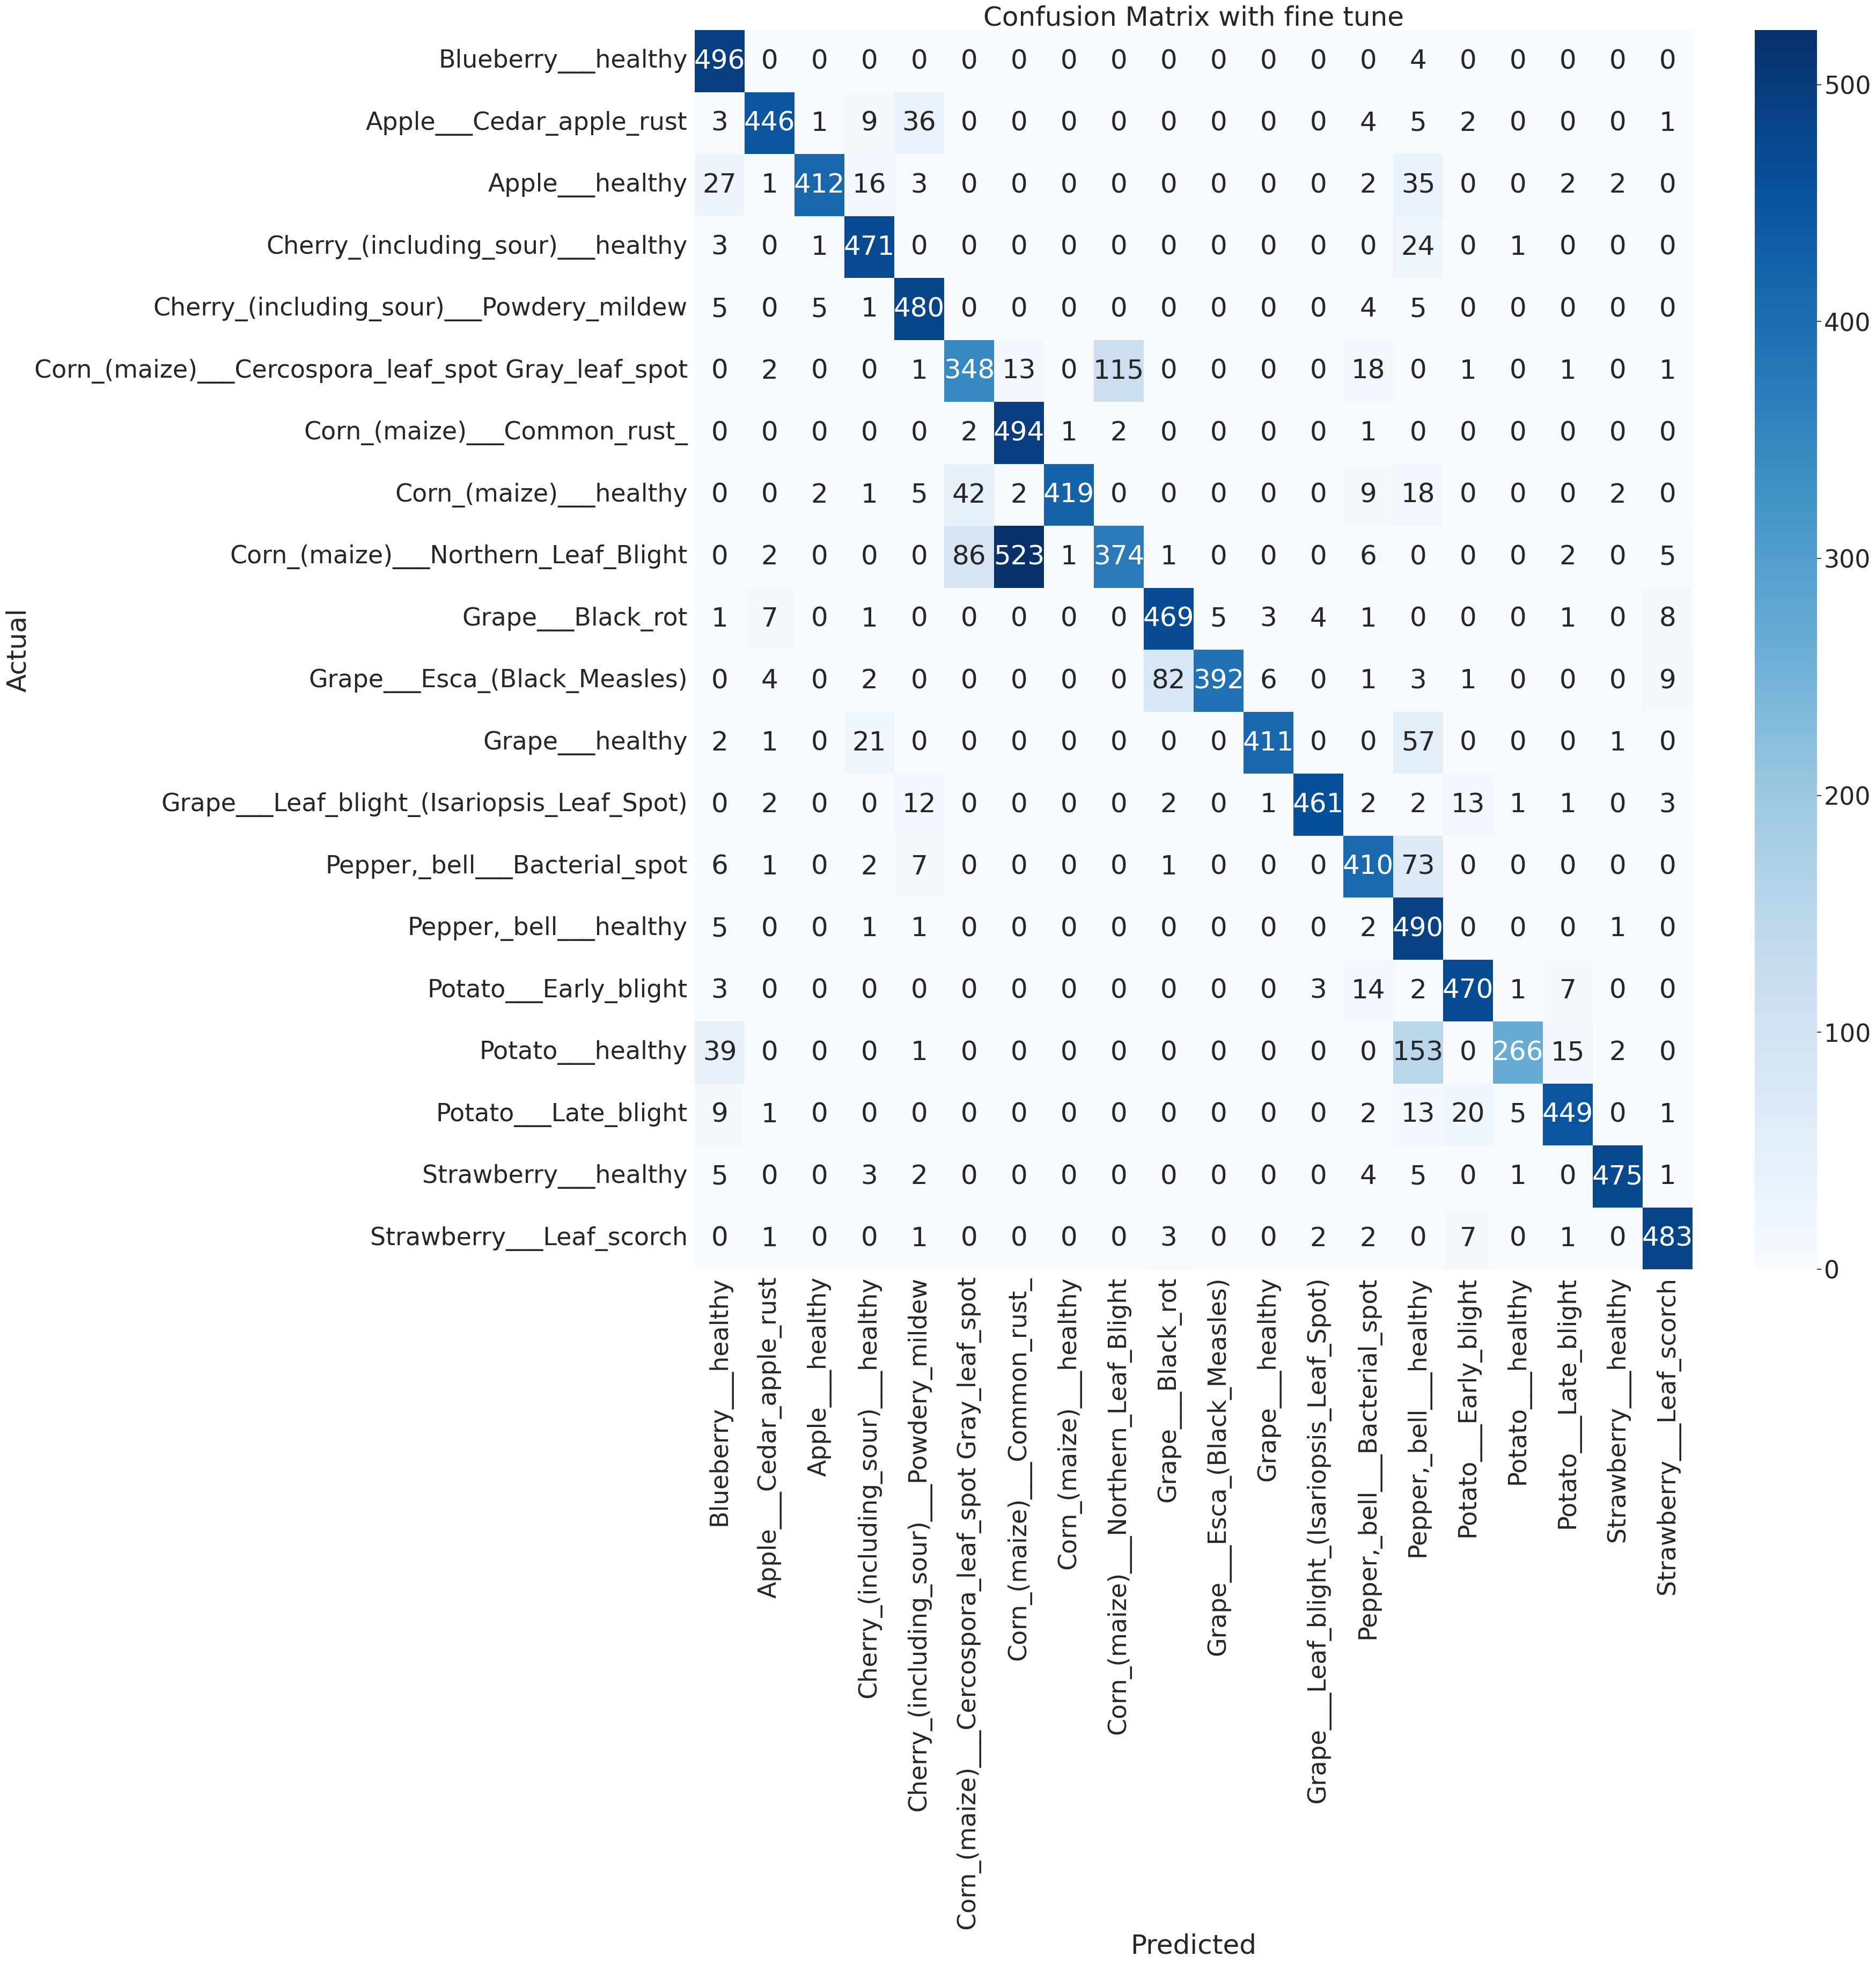

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
# Define class names if you have them
class_names = testgen.class_indices.keys()
# Create a heatmap
plt.figure(figsize=(30,30))
sns.set(font_scale=3)  # Adjust the font size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with fine tune')
plt.show()


In [ ]:
# Predict on the validation set
#y_pred = vgg_model_ft.predict(testgen)
y_pred = preds
y_true = testgen.classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
cm = confusion_matrix(y_true, y_pred_classes)
classification_rep = classification_report(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Display classification report, precision, recall, and F1 score
print("\nClassification Report:")
print(classification_rep)
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")


Confusion Matrix:
[[496   0   0   0   0   0   0   0   0   0   0   0   0   0   4   0   0   0
    0   0]
 [  3 446   1   9  36   0   0   0   0   0   0   0   0   4   5   2   0   0
    0   1]
 [ 27   1 412  16   3   0   0   0   0   0   0   0   0   2  35   0   0   2
    2   0]
 [  3   0   1 471   0   0   0   0   0   0   0   0   0   0  24   0   1   0
    0   0]
 [  5   0   5   1 480   0   0   0   0   0   0   0   0   4   5   0   0   0
    0   0]
 [  0   2   0   0   1 348  13   0 115   0   0   0   0  18   0   1   0   1
    0   1]
 [  0   0   0   0   0   2 494   1   2   0   0   0   0   1   0   0   0   0
    0   0]
 [  0   0   2   1   5  42   2 419   0   0   0   0   0   9  18   0   0   0
    2   0]
 [  0   2   0   0   0  86 523   1 374   1   0   0   0   6   0   0   0   2
    0   5]
 [  1   7   0   1   0   0   0   0   0 469   5   3   4   1   0   0   0   1
    0   8]
 [  0   4   0   2   0   0   0   0   0  82 392   6   0   1   3   1   0   0
    0   9]
 [  2   1   0  21   0   0   0   0   0   0   0 4

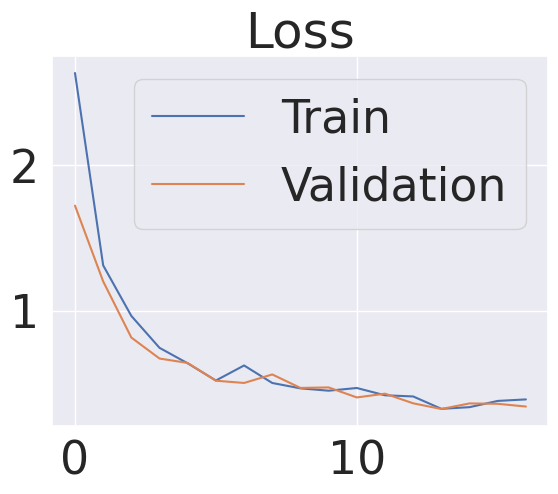

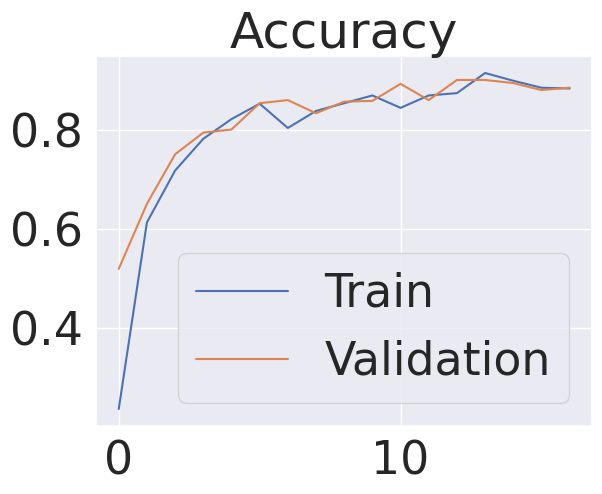

In [ ]:

loss_train_curve = fit_history.history["loss"]
loss_val_curve = fit_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()
acc_train_curve = fit_history.history["accuracy"]
acc_val_curve = fit_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

1/1 [==============================] - 0s 182ms/step


Text(0.5, 1.0, 'predicted: 0')

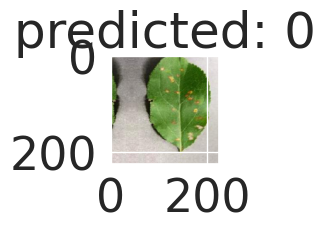

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

# Load an image from file
img_path = '/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset/ Augmented Dataset/Apple___Cedar_apple_rust/aug_0_3915.jpg'
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra dimension and preprocess the image
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
i=3
# Make the prediction
predictions = model.predict(img_array)
#print(predictions)
predicted = pred_classes[np.argmax(predictions)]
plt.subplot(240+1+i)
plt.imshow(img)
plt.title('predicted: ' + str(predicted))
# Decode and print the top-3 predicted classes
#decoded_predictions = decode_predictions(predictions, top=3)
#print(decoded_predictions)
